# Compare endogenous and exogenous overexpression

It is often asserted that overexpression leads to very high "non-physiological" levels of gene expression.
In this notebook we wanted to test this by comparing levels of gene expression in public single-cell datasets
with the levels of overexpression in the scTF-seq dataset. Of particular interest is the level of exogenous expression at which you
observe a significant change in gene expression.
Note the obvious limitations of this approach.
1. We may underestimate physiological levels if:
- Some states of interest may not be present in the public atlas
- Clusters are defined too broad in the public atlas
2. We may underestimate exogenous levels if:
- The overexpression leads to mRNAs that are more easily translated

First run [1-download_census.py](1-download_census.py) to download the data and create the adata object.
Then run this notebook [2-create_figures.py](2-create_figures.py) to combine the data with scTFseq data.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import tqdm.auto as tqdm

import polyptich as pp

pp.setup_ipython()

import scanpy as sc

import pickle

In [2]:
data_folder = pp.paths.get_data()

In [3]:
obs_alltfs = (
    pd.read_csv(data_folder / "obs.csv").rename(columns={"Unnamed: 0": "cell"}).set_index("cell")
)
mtx = scipy.io.mmread("matrix.mtx").T.tocsr()
obs_alltfs["ix"] = range(obs_alltfs.shape[0])

var_alltfs = pd.read_csv(data_folder / "var.csv", index_col=0)

In [4]:
obs_alltfs["activity_to_D0"] = (
    pd.read_csv(
        data_folder / "df_allG1Cells_PhaseCorrected_allTFs_D0regressed10pc_50pc_integrated.csv"
    )
    .set_index("cell")["Activity_TF_to_D0"]
    .reindex(obs_alltfs.index)
)

Define a set of housekeeping genes to compare against.
We explicitely chose a set of genes from different essential functions such as cytoskeleton, ribosomal proteins, glycolysis, ubiquitinilation, respiration, and translation.

In [5]:
# housekeeping was defined in the 1-download_census script
housekeeping = pickle.load(open("housekeeping.pkl", "rb"))
tfs = obs_alltfs["TF"].unique().tolist()

In [6]:
from plot_endogenous import extract_tf_dataset

In [7]:
tfcapacity = pd.read_csv(
    data_folder / "TF_categories_on_potency_capacity_dosealigned.csv", index_col=0
)
tfcapacity.index.name = "TF"

# Load data

In [ ]:
datasets = pickle.load(open("datasets.pkl", "rb"))

adata = pickle.load(open("adata2.pkl", "rb"))
adata.var.index = adata.var.feature_name

adata.obs["dataset_ix"] = pd.Series(datasets.index, index = datasets["dataset_id"])[adata.obs["dataset_id"]].values

adata.obs["n_counts"] = adata.X.sum(axis=1).A1
adata.obs["norm"] = 1 / (adata[:, housekeeping].X.sum(1).A1 + 1)
adata = adata[adata.obs["norm"] < 0.5].copy() # remove cells with extremely low expression of housekeeping

adata.layers["norm"] = adata.X.copy()
adata.layers["norm"] = (
    adata.layers["norm"].multiply(adata.obs["norm"].values[:, None]).tocsr()
)

We extract the datasets for Myo_ref and Adipo_ref, to see how enodogenous TF expression changes during induction of myogenesis and adipogenesis in our C3H10T1/2 cells.

In [14]:
adatamyo = extract_tf_dataset(mtx, obs_alltfs, var_alltfs, "Myo_ref", housekeeping=housekeeping)
adatamyo = adatamyo[adatamyo.obs["Phase_corrected"] == "G1"]
adatamyo = adatamyo[adatamyo.obs["TF"] == "Myo_ref"]
adatamyo = adatamyo[adatamyo.obs.index[:200]]

adataadipo = extract_tf_dataset(mtx, obs_alltfs, var_alltfs, "Adipo_ref", housekeeping=housekeeping)
adataadipo = adataadipo[adataadipo.obs["Phase_corrected"] == "G1"]
adataadipo = adataadipo[adataadipo.obs["TF"] == "Adipo_ref"]
adataadipo = adataadipo[adataadipo.obs.index[:200]]

## Individual

In [26]:
gene = "Hnf4g"
# gene = "Zeb1"
# gene = "Hoxa9"
# gene = "Myod1"
# gene = "Myog"
# gene = "Pparg"
# gene = "Cebpa"
gene = "Runx2"
tf = gene

In [27]:
from plot_endogenous import plot as plot_endogenous

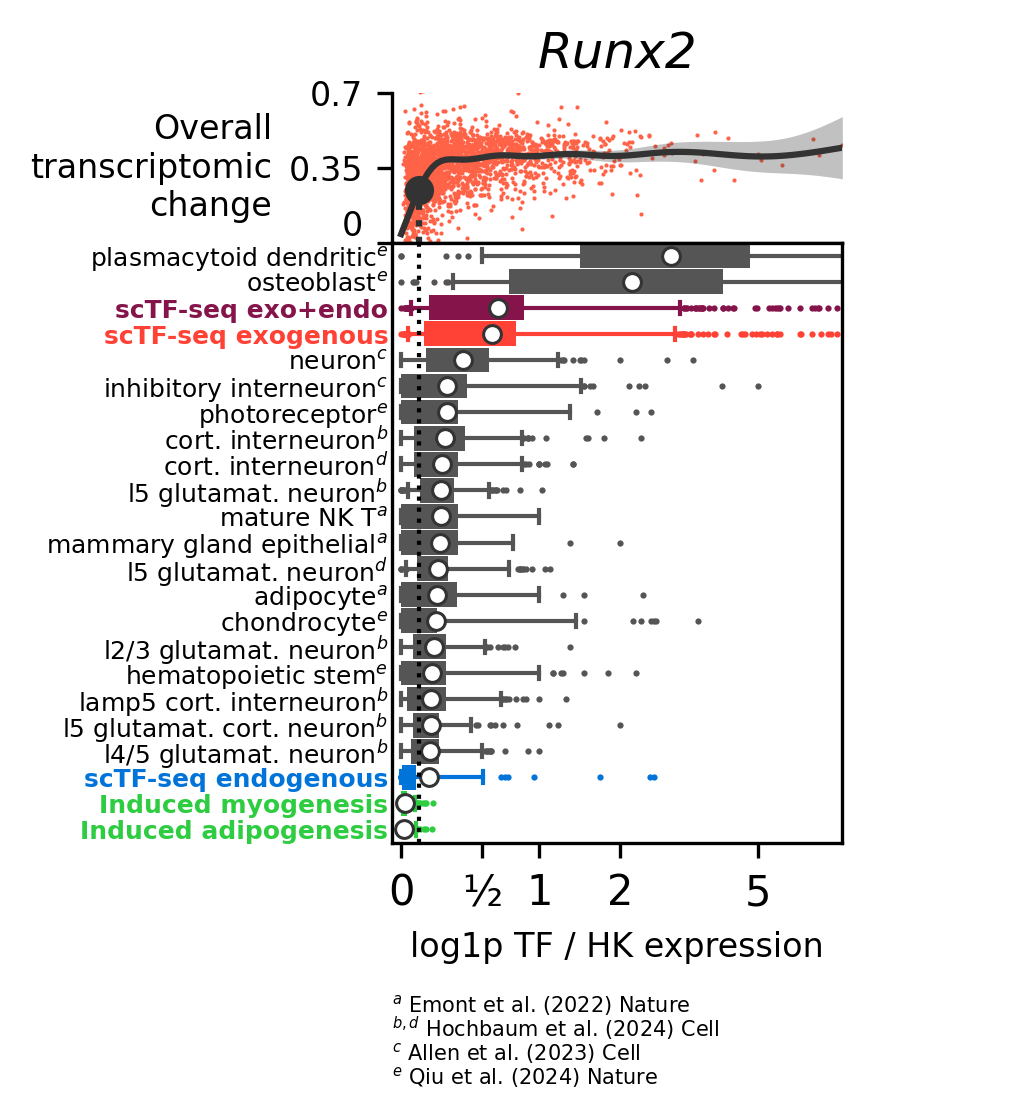

In [30]:
tf = "Runx2"
fig = plot_endogenous(
    mtx, obs_alltfs, var_alltfs, tf, tf, housekeeping, adata, datasets=datasets, adatamyo = adatamyo, adataadipo = adataadipo, n_top = 20, width = 1.5
)
fig.display()

  0%|          | 0/7 [00:00<?, ?it/s]

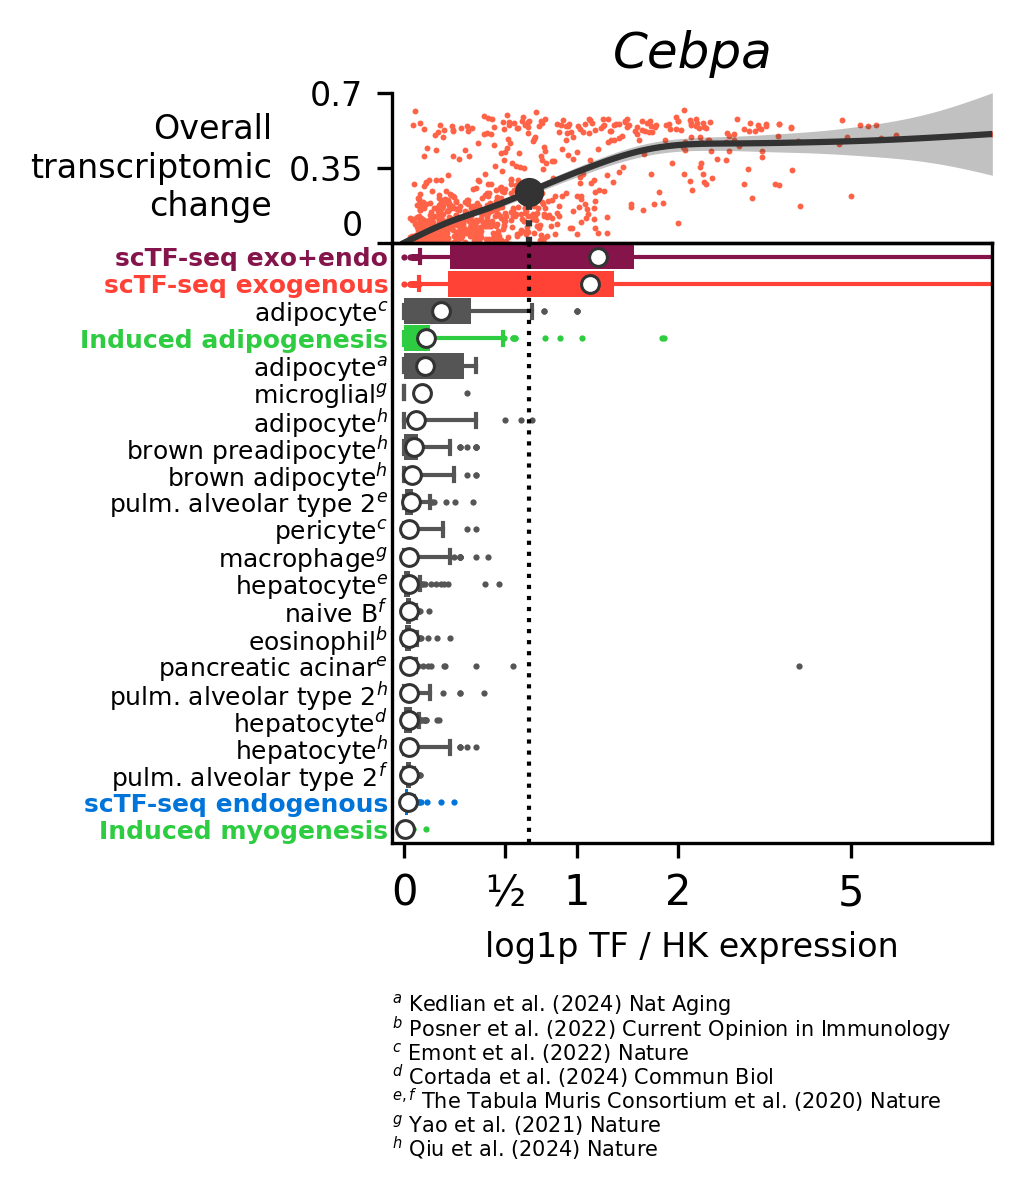

 14%|█▍        | 1/7 [00:01<00:08,  1.37s/it]

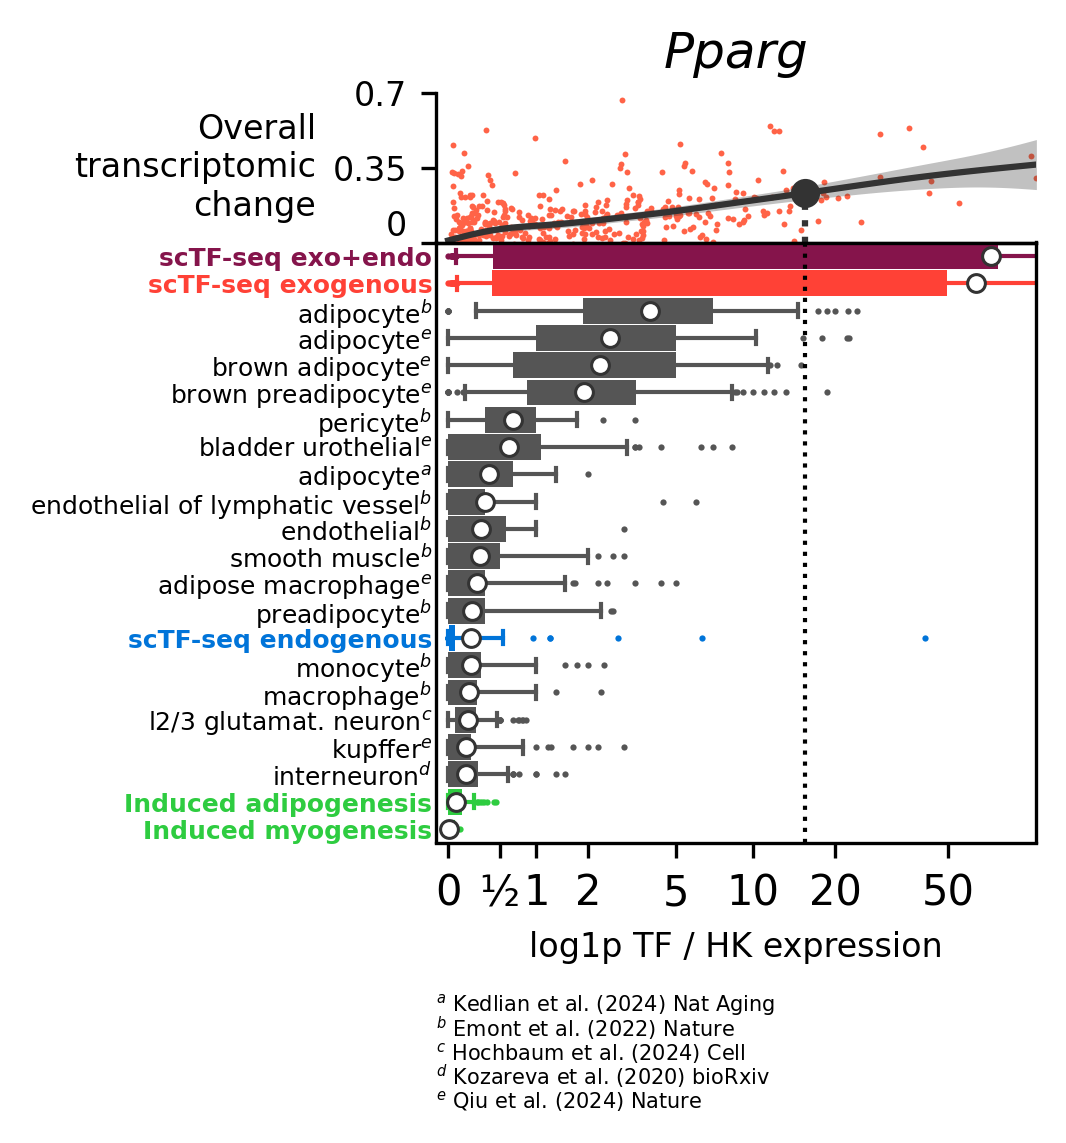

 29%|██▊       | 2/7 [00:02<00:06,  1.33s/it]

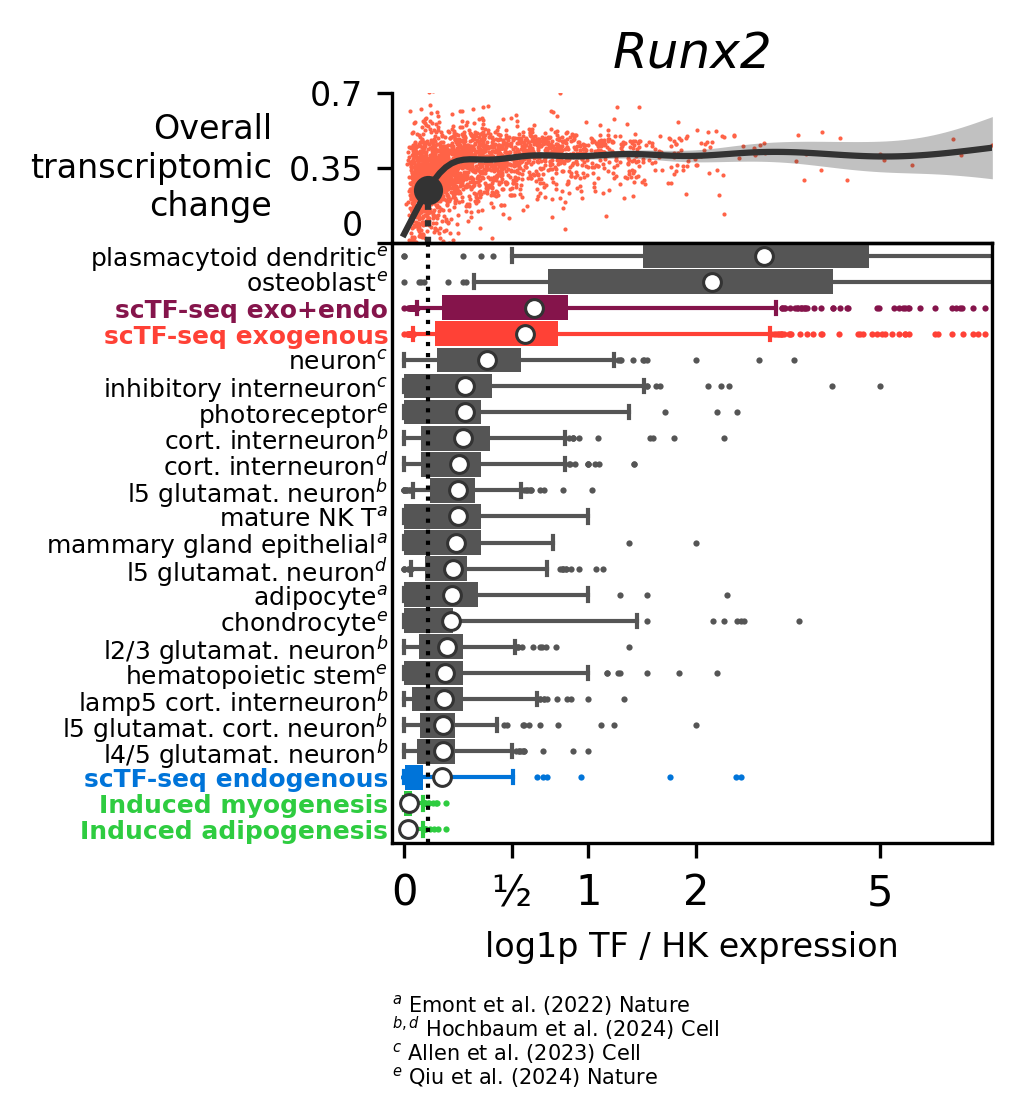

 43%|████▎     | 3/7 [00:04<00:05,  1.49s/it]

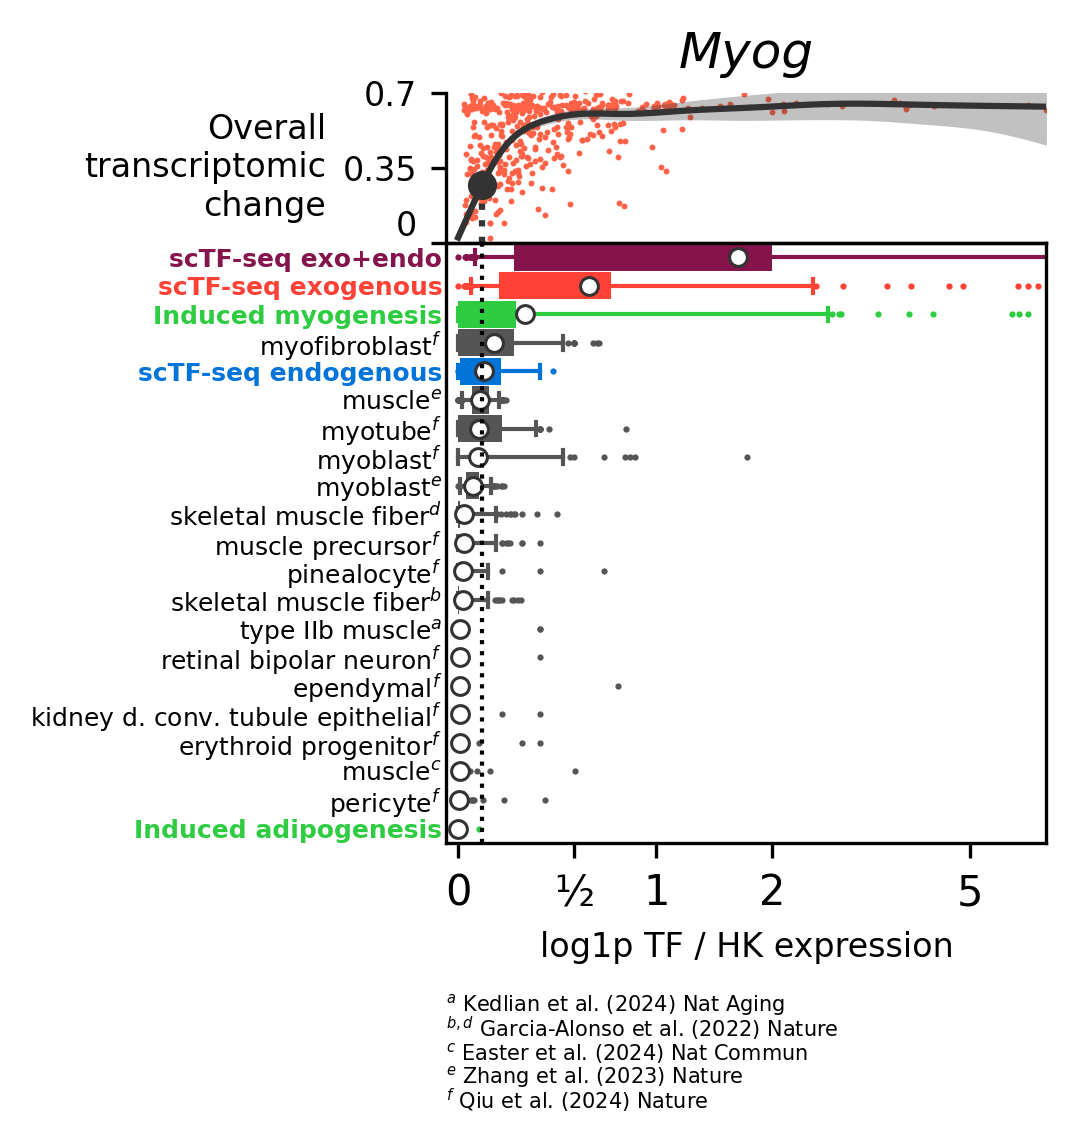

 57%|█████▋    | 4/7 [00:05<00:04,  1.39s/it]

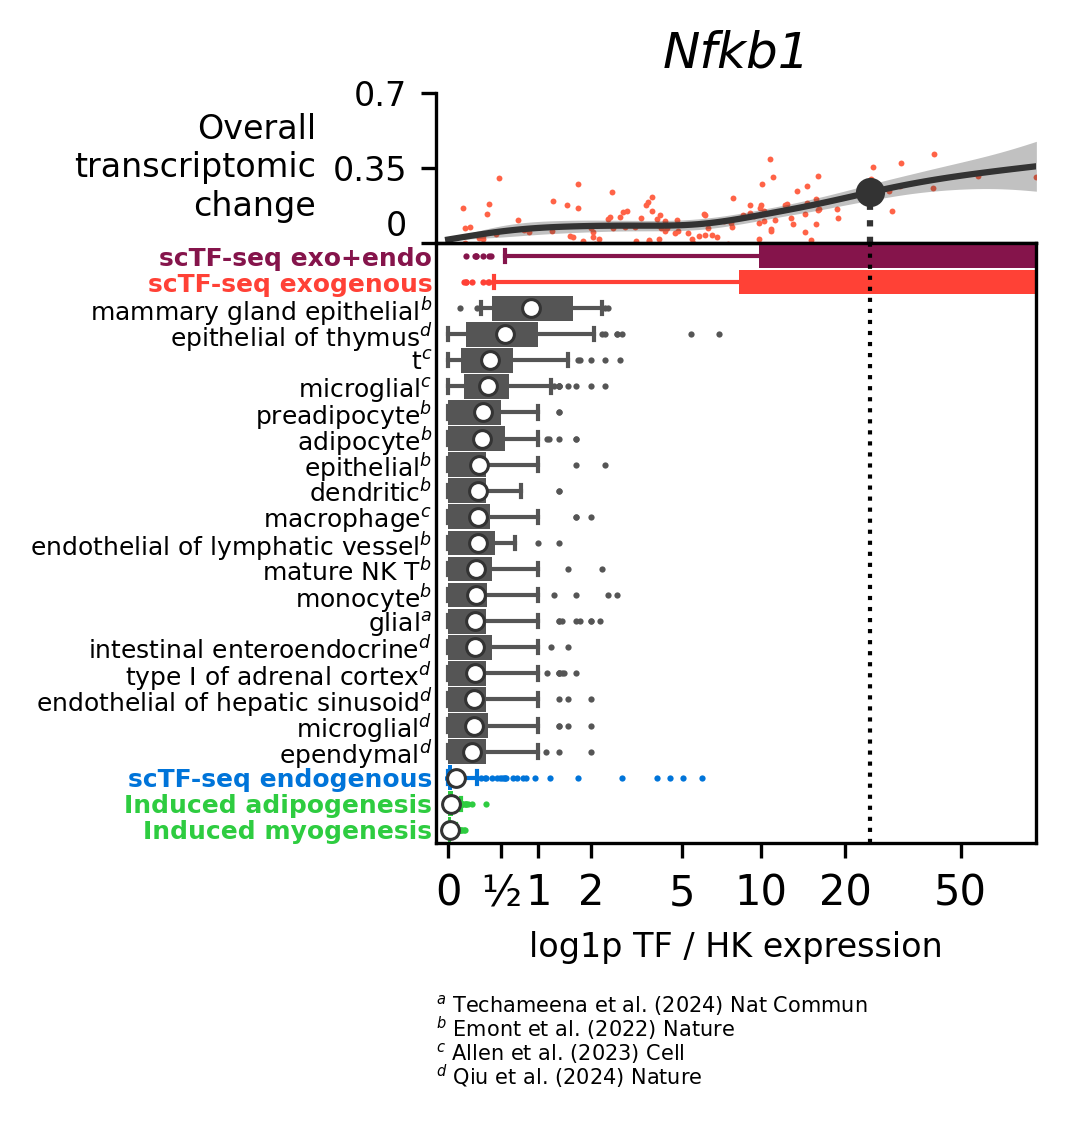

 71%|███████▏  | 5/7 [00:06<00:02,  1.34s/it]

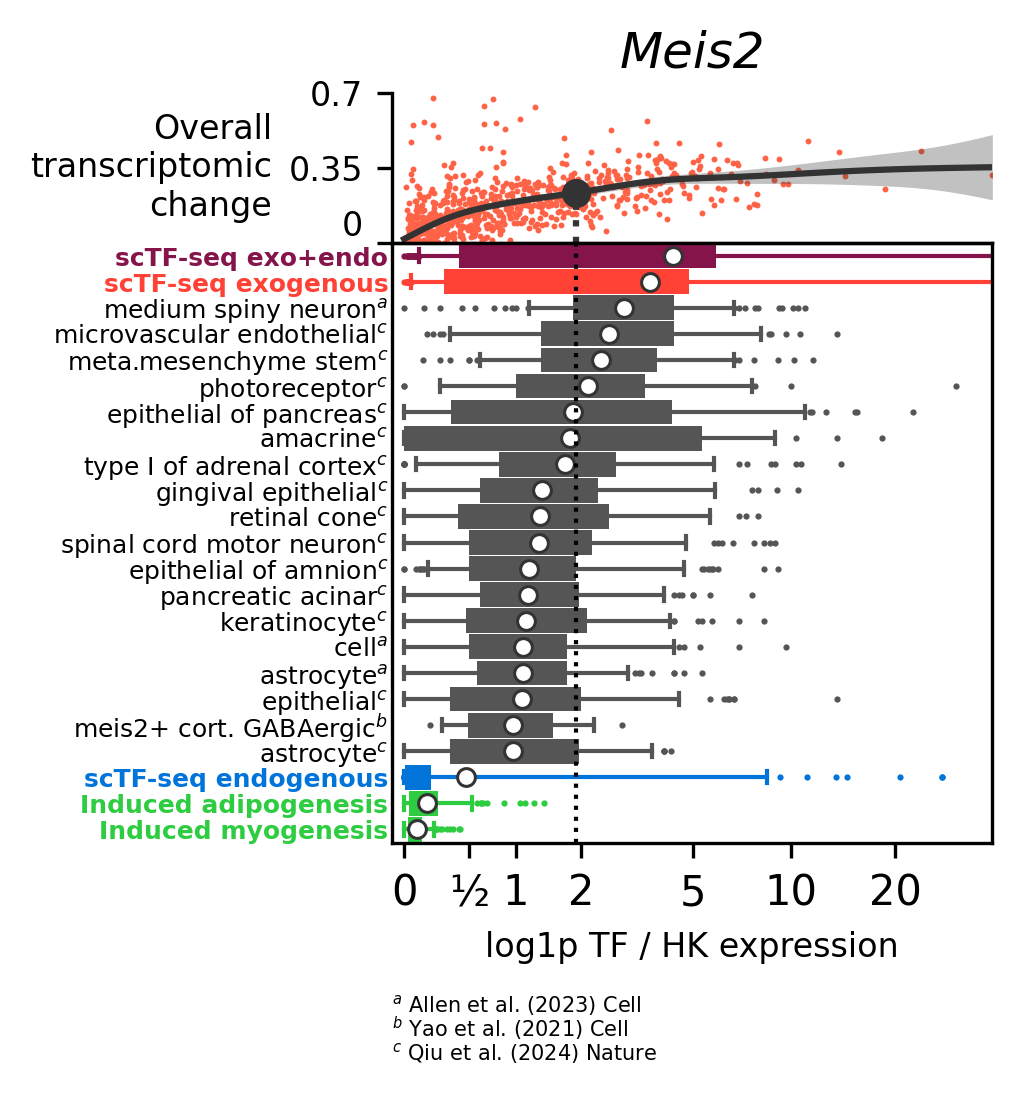

 86%|████████▌ | 6/7 [00:08<00:01,  1.33s/it]

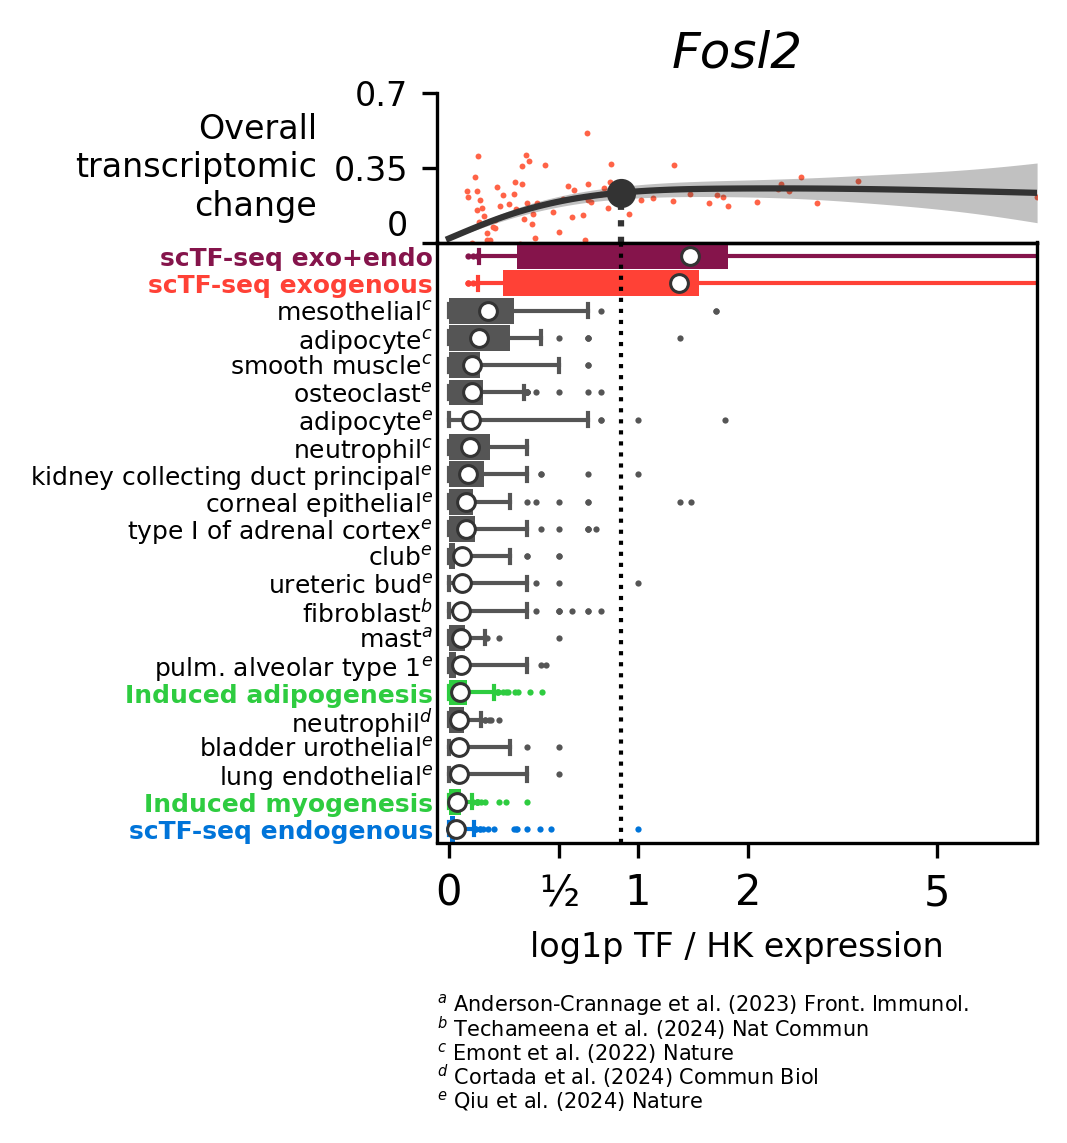

100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


In [31]:
import pathlib
import tqdm

plot_folder = pathlib.Path("./plots_endogenous")
import shutil

# shutil.rmtree(plot_folder, ignore_errors=True)
plot_folder.mkdir(exist_ok=True)

tfs_oi = [tf for tf in tfs if tf in adata.var.index]
tfs_oi = ["Cebpa", "Pparg", "Runx2", "Myog", "Nfkb1", "Meis2", "Fosl2"]

for gene in tqdm.tqdm(tfs_oi):
    fig = plot_endogenous(
        mtx, obs_alltfs, var_alltfs, gene, gene, housekeeping, adata, datasets=datasets, adatamyo = adatamyo, adataadipo = adataadipo
    )
    fig.savefig(plot_folder / f"{gene}.pdf", display = False, transparent=True)
    fig.savefig(plot_folder / f"{gene}.png", display = True, transparent=True)

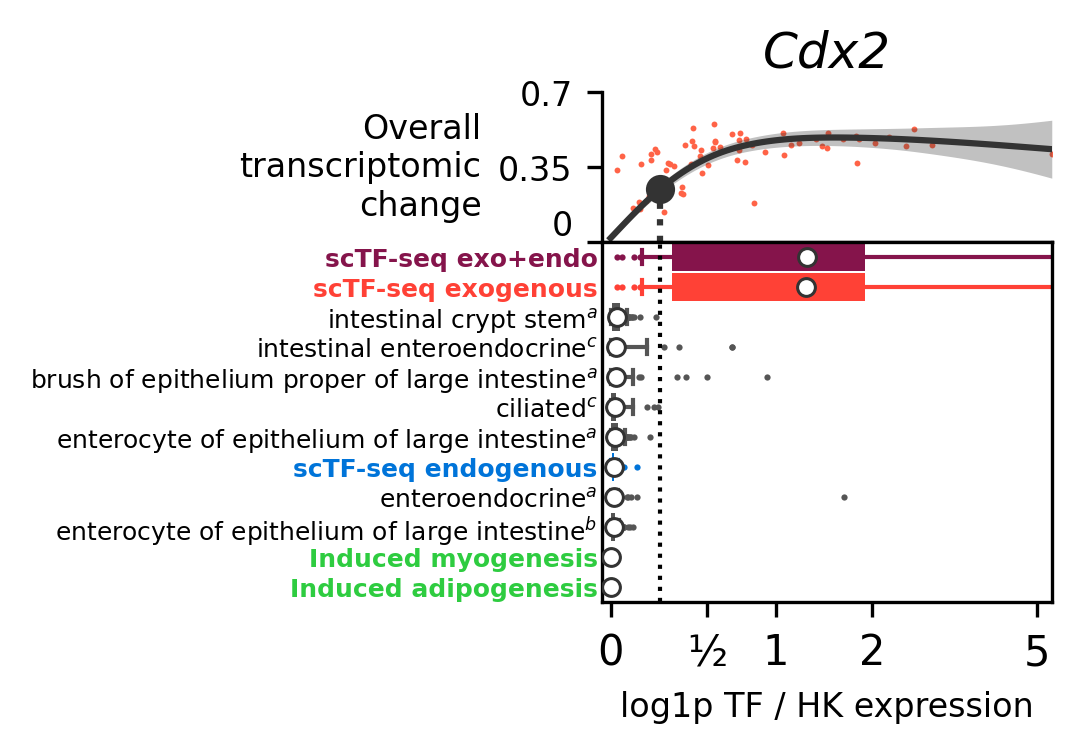

In [32]:
citations = {}
fig = plot_endogenous(
        mtx, obs_alltfs, var_alltfs, "Cdx2", "Cdx2", housekeeping, adata, datasets=datasets, adatamyo = adatamyo, adataadipo = adataadipo, width = 1.5, n_top = 10, add_citations = False, citations = citations
    )
fig.display()

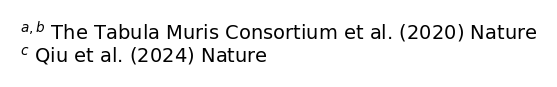

In [33]:
datasets_oi = datasets.loc[citations.keys()]
datasets_oi["footnote_symbol"] = [citations[x] for x in datasets_oi.index]
plotdata = datasets_oi.groupby("collection_doi_label").agg(
    {"footnote_symbol": tuple}
)
plotdata = plotdata.sort_values("footnote_symbol", ascending=False)
plotdata["ix"] = range(plotdata.shape[0])

fig, ax = plt.subplots(figsize = (2, len(plotdata) * 0.15))
for label, dataset in plotdata.iterrows():
    label = label.replace("The Tabula Sapiens Consortium* et al.", "Tabula Sapiens")
    ax.text(
        0,
        dataset["ix"],
        f"$^{{{','.join(dataset['footnote_symbol'])}}}$ {label}",
        ha="left",
        va="center",
        fontsize=7,
    )
ax.set_ylim(-0.5, len(plotdata) - 0.5)
ax.axis("off")
fig.savefig(plot_folder / f"small_footnotes.pdf", transparent=True)

## Global

In [34]:
from plot_endogenous import smooth_spline_fit_se, abbreviate_sentence

tfs_oi = ["Runx2"]
tfs_oi = tfcapacity.query("category != 'low-capacity'").index
tfs_oi = [x for x in tfcapacity.index if x not in ["Pparg1", "Spert"]]
tfs_oi = [x for x in tfs_oi if x in adata.var.index]

tfscores_exogenous = []
for gene in tqdm.tqdm(tfs_oi, mininterval = 2):
    adatatf = extract_tf_dataset(mtx, obs_alltfs, var_alltfs, gene, housekeeping)
    adatatf = adatatf[adatatf.obs["Phase_corrected"] == "G1"].copy()
    adatatf.obs["target"] = adatatf.obs["activity_to_D0"]

    plotdata = pd.DataFrame(
        {
            "expression": np.log(adatatf.obs["Vector_10X_norm"] + 1),
            "dataset_cell_type": "scTF-seq",
            "target": adatatf.obs["target"],
        }
    )
    plotdata_0 = plotdata.loc[plotdata["expression"] == 0]
    plotdata_non0 = plotdata.loc[plotdata["expression"] != 0]

    extent = plotdata_non0["expression"].max()
    extent_left = -extent * 0.02
    plotdata_smooth = pd.DataFrame(
        {
            "expression": np.linspace(0, extent, 100),
        }
    )
    plotdata_smooth["target"], plotdata_smooth["target_se"] = smooth_spline_fit_se(
        plotdata["expression"], plotdata["target"], plotdata_smooth["expression"]
    ).T

    cutoff = 0.23
    if plotdata_smooth["target"].max() < cutoff:
        target = plotdata_smooth["expression"].loc[
                plotdata_smooth["target"].argmax()
            ]
    else:
        target = plotdata_smooth["expression"][
            plotdata_smooth["target"] > cutoff
        ].iloc[0]


    tfscores_exogenous.append(
        {
            "tf": gene,
            "target_03": target,
            "max_dose": plotdata_smooth["expression"].max(),
            "never_reached": plotdata_smooth["target"].max() < cutoff,
        }
    )

tfscores_exogenous = pd.DataFrame(tfscores_exogenous)

100%|██████████| 227/227 [00:21<00:00, 10.52it/s]


In [35]:
tfscores_endogenous = []

for gene in tqdm.tqdm(tfs_oi, mininterval = 2):
    plotdata = pd.DataFrame(
        {
            "expression": np.log1p(sc.get.obs_df(adata, gene, layer="norm").values[:, 0]),
            "dataset_ix": adata.obs["dataset_ix"],
            "cell_type": adata.obs["cell_type"],
        }
    )
    plotdata["dataset_cell_type"] = (
        plotdata["cell_type"].astype(str).apply(abbreviate_sentence, max_length=50)
        + " "
        + plotdata["dataset_ix"].astype(str)
    )

    dataset_cell_type_oi = (
        plotdata.groupby("dataset_cell_type")["expression"]
        .mean()
        .sort_values(ascending=False)
        .index[0]
    )
    plotdata_oi = plotdata.query("dataset_cell_type == @dataset_cell_type_oi")

    tfscores_endogenous.append(
        {
            "q90": plotdata_oi["expression"].quantile(0.90),
            "q95": plotdata_oi["expression"].quantile(0.94),
            "q99": plotdata_oi["expression"].quantile(0.99),
            "q10": plotdata_oi["expression"].quantile(0.10),
            "q05": plotdata_oi["expression"].quantile(0.05),
            "mean": plotdata_oi["expression"].mean(),
            "tf": gene,
            "med": plotdata_oi["expression"].median(),
            "cell_type": ' '.join(dataset_cell_type_oi.split(" ")[:-1]),
        }
    )
tfscores_endogenous = pd.DataFrame(tfscores_endogenous)

100%|██████████| 227/227 [01:10<00:00,  3.20it/s]


In [36]:
tfscores = tfscores_exogenous.merge(tfscores_endogenous, on="tf")

In [37]:
(tfscores["target_03"] < tfscores["q95"]).mean()

np.float64(0.2555066079295154)

In [38]:
tfscores.query("target_03 < q95").sort_values("target_03")
# tfscores.query("target_03 > q95")

,tf,target_03,max_dose,never_reached,q90,q95,q99,q10,q05,mean,med,cell_type
155,Yap1,0.072797,1.201152,False,0.693147,0.700772,0.828469,0.012021,0.000000,0.350047,0.318454,mammary gland epithelial
26,Myod1,0.080944,1.335579,False,0.351850,0.461144,0.826536,0.000000,0.000000,0.091071,0.000000,skeletal muscle satellite
7,Myog,0.083126,2.057374,False,0.293836,0.366375,0.471864,0.000000,0.000000,0.126268,0.095310,myofibroblast
148,Runx2,0.089475,2.214504,False,2.297560,2.469549,3.152662,0.604156,0.388217,1.354819,1.280934,plasmacytoid dendritic
158,Pou3f2,0.094864,0.284591,False,0.266785,0.323203,0.452526,0.000000,0.000000,0.112960,0.071038,unknown
179,T,0.097016,0.960462,False,1.229361,1.330191,1.444994,0.386110,0.365783,0.755934,0.693147,ciliated
138,Gata4,0.101853,0.373462,False,0.782097,0.981183,1.271637,0.000000,0.000000,0.387520,0.336472,pancreatic acinar
122,Tfeb,0.106412,1.053480,False,0.510826,0.583754,0.847298,0.000000,0.000000,0.204121,0.182322,kidney collecting duct intercalated
169,Klf4,0.112454,2.226584,False,0.256528,0.275765,0.422939,0.021746,0.013360,0.131299,0.121885,fibroblast
157,Foxa1,0.136052,1.036092,False,0.287682,0.326306,0.455033,0.000000,0.000000,0.098589,0.000000,mammary gland epithelial


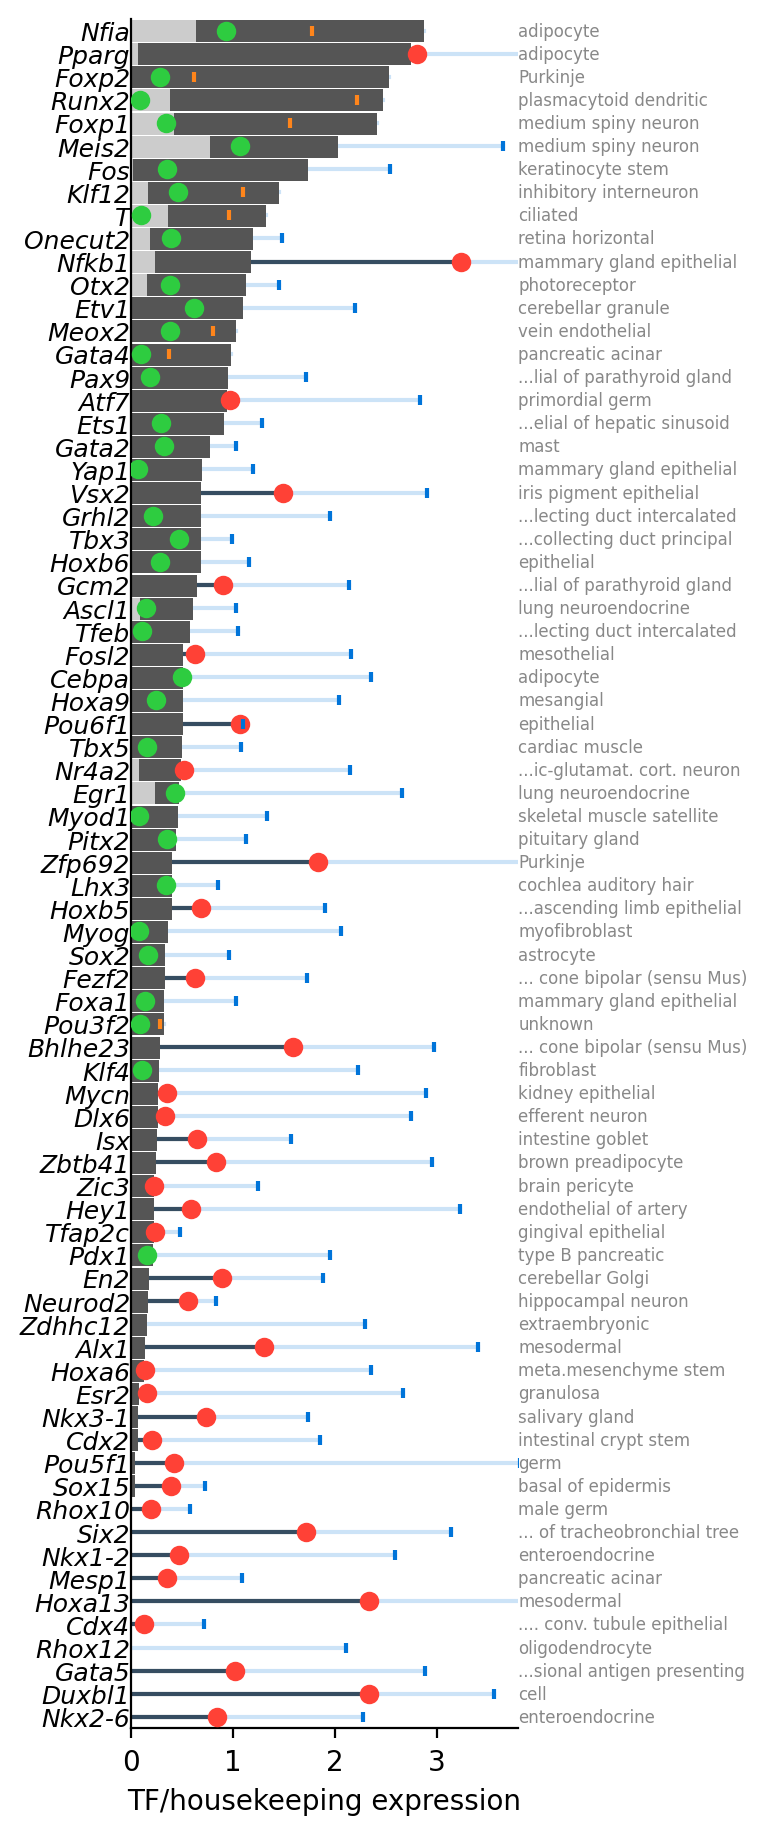

In [39]:
# plotdata = tfscores.loc[~plotdata["never_reached"]]
plotdata = tfscores.loc[tfscores["tf"].isin(tfcapacity.query("category != 'low-capacity'").index)]

plotdata = plotdata.sort_values(["q95"])
plotdata["ix"] = range(len(plotdata))
fig, ax = plt.subplots(figsize = (2.5, len(plotdata) * 0.15))
for _, row in plotdata.iterrows():
    rect = plt.Rectangle(
        (row["q05"], row["ix"]),
        row["q95"] - row["q05"],
        0.95,
        color="#555",
        lw = 0,
    )
    ax.add_patch(rect)
    rect2 = plt.Rectangle(
        (0, row["ix"]),
        row["q05"],
        0.95,
        color="#CCC",
        lw = 0,
    )
    ax.add_patch(rect2)

    # med
    # plt.plot([row["mean"], row["mean"]], [row["ix"], row["ix"] + 1], color="#555")

    if not row["never_reached"]:
        color = "#2ECC40" if row["target_03"] < row["q95"] else "#FF4136"
        plt.scatter(row["target_03"], row["ix"]+0.5, color=color, marker = "o", zorder = 10)
        # connect dot to q95 if outside of range
        if row["target_03"] > row["q95"]:
            plt.plot(
                [row["q95"], row["target_03"]],
                [row["ix"] + 0.5, row["ix"] + 0.5],
                color="#444",linestyle = "-",
                zorder = -1
            )

    color = "#0074D9" if row["max_dose"] > row["q95"] else "#FF851B"
    # marker = "." if not row["never_reached"] else "x"
    marker = "|"
    ax.scatter(
        row["max_dose"], row["ix"] + 0.5, color=color, marker=marker, zorder=10, s = 15
    )
    ax.plot(
        [row["max_dose"], row["q95"]],
        [row["ix"] + 0.5, row["ix"] + 0.5],
        color="#0074D9",
        linestyle="-",
        alpha = 0.2,
        zorder=-1,
    )

    label = row["cell_type"]
    if len(label) > 27:
        label = "..." + label[-25:]
    ax.text(1, row["ix"] + 0.5, label, va="center", ha="left", transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData), fontsize = 6, color = "#888")
# for ix in plotdata["ix"].iloc[::2]:
#     plt.axhspan(ix, ix+1, color="#EEE", zorder=-10)

ax.set_yticks(plotdata["ix"] + 0.5)
ax.set_yticklabels(plotdata["tf"], fontstyle = "italic", fontsize = 9)
ax.tick_params(axis="y", which="major", pad=0.2, length=0)
ax.set_xlim(0, 3.8)
ax.set_ylim(0., len(plotdata))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("TF/housekeeping expression")

import pathlib
plot_folder = pathlib.Path("plots_endogenous")
fig.savefig(plot_folder / "endogenous_global.pdf", bbox_inches="tight")
fig.savefig(plot_folder / "endogenous_global.png", bbox_inches="tight")

In [40]:
tfscores_high_capacity = tfscores.loc[tfscores["tf"].isin(tfcapacity.query("category != 'low-capacity'").index)]

In [41]:
print(f"""
Among all TFs (after pre-filtering, so 270), {(tfscores["target_03"] < tfscores["q95"]).mean():.0%}. Among all high-capacity TFs (76), {(tfscores_high_capacity["target_03"] < tfscores_high_capacity["q95"]).mean():.0%}.
""")


Among all TFs (after pre-filtering, so 270), 26%. Among all high-capacity TFs (76), 47%.



In [42]:
tfscores.query("target_03 < q95").sort_values("target_03")

,tf,target_03,max_dose,never_reached,q90,q95,q99,q10,q05,mean,med,cell_type
155,Yap1,0.072797,1.201152,False,0.693147,0.700772,0.828469,0.012021,0.000000,0.350047,0.318454,mammary gland epithelial
26,Myod1,0.080944,1.335579,False,0.351850,0.461144,0.826536,0.000000,0.000000,0.091071,0.000000,skeletal muscle satellite
7,Myog,0.083126,2.057374,False,0.293836,0.366375,0.471864,0.000000,0.000000,0.126268,0.095310,myofibroblast
148,Runx2,0.089475,2.214504,False,2.297560,2.469549,3.152662,0.604156,0.388217,1.354819,1.280934,plasmacytoid dendritic
158,Pou3f2,0.094864,0.284591,False,0.266785,0.323203,0.452526,0.000000,0.000000,0.112960,0.071038,unknown
179,T,0.097016,0.960462,False,1.229361,1.330191,1.444994,0.386110,0.365783,0.755934,0.693147,ciliated
138,Gata4,0.101853,0.373462,False,0.782097,0.981183,1.271637,0.000000,0.000000,0.387520,0.336472,pancreatic acinar
122,Tfeb,0.106412,1.053480,False,0.510826,0.583754,0.847298,0.000000,0.000000,0.204121,0.182322,kidney collecting duct intercalated
169,Klf4,0.112454,2.226584,False,0.256528,0.275765,0.422939,0.021746,0.013360,0.131299,0.121885,fibroblast
157,Foxa1,0.136052,1.036092,False,0.287682,0.326306,0.455033,0.000000,0.000000,0.098589,0.000000,mammary gland epithelial


In [43]:
(tfscores["target_03"] < tfscores["q95"]).mean()

np.float64(0.2555066079295154)